## Project: Dog Breed Identification using Convolutional Neural Networks

---
### Project Overview:

In this notebook, we will take the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.

We break the notebook into separate steps:

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write our Algorithm
* [Step 7](#step7): Test our Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
#This cell is used to avoid GPU timeout
# import requests
# response = requests.request("GET", "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", headers={"Metadata-Flavor":"Google"})
# token = response.text

# # add the next line to run in each iteration of your main training loop
# requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + token})

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    #sklearn.datasets.load_files(container_path, description=None, categories=None, load_content=True, 
    #shuffle=True, encoding=None, decode_error=’strict’, random_state=0)
    #Load text files with categories as subfolder names.
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    #np.utils.to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
#The glob module finds all the pathnames matching a specified pattern according to 
#the rules used by the Unix shell, although results are returned in arbitrary order.
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(42)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
#Modify a sequence in-place by shuffling its contents. 
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we see how to use this detector to find human faces in a sample image.

Number of faces detected: 1


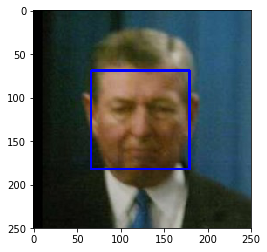

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### IMPLEMENTATION: Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## We test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
humans_detected_as_human_list= [1 if face_detector(human) else 0 for human in human_files_short ]
dogs_detected_as_human_list =[1 if face_detector(dog) else 0 for dog in dog_files_short ]

humans_detected_as_human_count = sum(humans_detected_as_human_list) 
dogs_detected_as_human_count = sum(dogs_detected_as_human_list) 
    
print("Detected {} humans in human files of total {} , ratio: {}".format(humans_detected_as_human_count,len(human_files_short),humans_detected_as_human_count/len(human_files_short) ) )
print("Detected {} humans in dog files of total {} , ratio: {}".format(dogs_detected_as_human_count,len(dog_files_short),dogs_detected_as_human_count/len(dog_files_short) ) )

Detected 100 humans in human files of total 100 , ratio: 1.0
Detected 11 humans in dog files of total 100 , ratio: 0.11


**Observation**: Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.


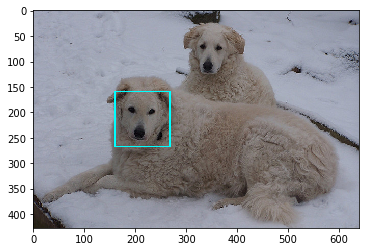

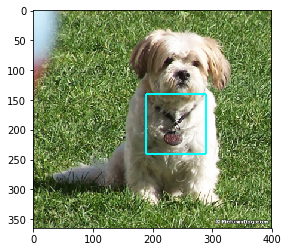

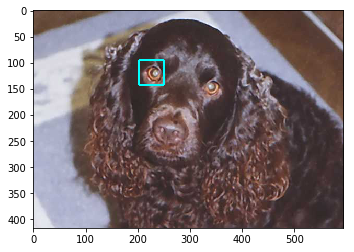

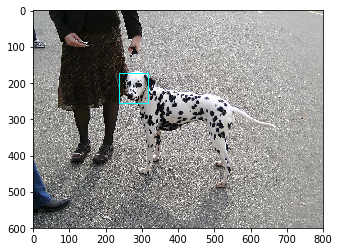

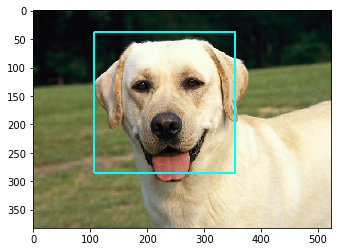

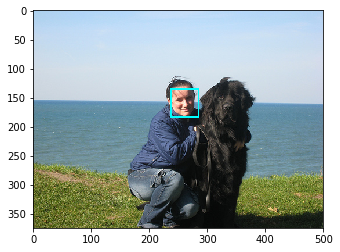

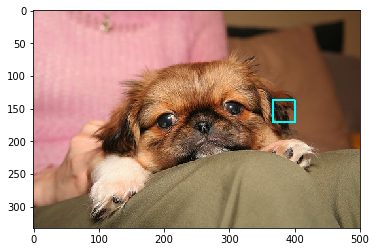

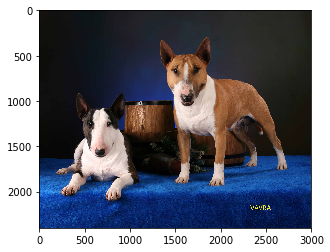

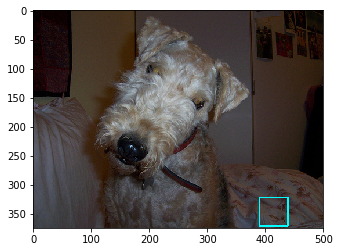

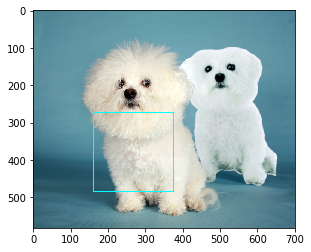

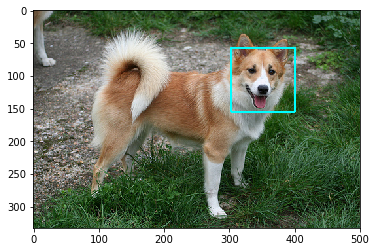

In [6]:
##Show dogs detected as human
for i,v in enumerate(dogs_detected_as_human_list):
    if v == 1:
        img = cv2.imread(dog_files_short[i])
        # convert BGR image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find faces in image
        faces = face_cascade.detectMultiScale(gray)
        # get bounding box for each detected face
        for (x,y,w,h) in faces:
            # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)

        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
        plt.imshow(cv_rgb)
        plt.show()

**Note**: This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In my opinion I think that if the web app mantains it really clear in the UI that it needs a clear view of a face, it is acceptable. A way to detect humans in images could be to train a CNN with many human images in different angles and an augmented data set to be able to do that. The face detector from OpenCV is a potential way to detect human images in our algorithm below is the code.

Number of faces detected: 1


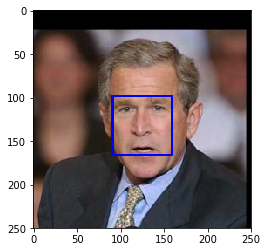

In [7]:
## The performance of another face detection algorithm on the LFW dataset

face_cascade_lbp = cv2.CascadeClassifier('haarcascades/lbpcascade_frontalface_improved.xml')

#alternate detector
def face_detector_lbp(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade_lbp.detectMultiScale(gray)
    return len(faces) > 0

# load color (BGR) image
img = cv2.imread(human_files[110])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade_lbp.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [8]:
human_human_detected_count = sum(1 for is_human in human_files_short if face_detector_lbp(is_human)) 
dog_human_detected_count = sum(1 for is_human in dog_files_short if face_detector_lbp(is_human)) 
    
print("Detected {} humans in human files of total {} , ratio: {}".format(human_human_detected_count,len(human_files_short),human_human_detected_count/len(human_files_short) ) )
print("Detected {} humans in dog files of total {} , ratio: {}".format(dog_human_detected_count,len(dog_files_short),dog_human_detected_count/len(dog_files_short) ) )

Detected 87 humans in human files of total 100 , ratio: 0.87
Detected 1 humans in dog files of total 100 , ratio: 0.01


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  We can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### MPLEMENTATION: Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### We test the performance of the dog_detector function
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_count = 0
for human_picture in human_files_short:
    human_count += int(dog_detector(human_picture))
human_acc = human_count / 100.0

dog_count = 0
for dog_picture in dog_files_short:
    dog_count += int(dog_detector(dog_picture))
dog_acc = dog_count / 100.0

print("Human accuracy: {}%".format(human_acc * 100))
print("dog accuracy: {}%".format(dog_acc * 100))

Human accuracy: 1.0%
dog accuracy: 100.0%


**Observation**:  
- Percentage of the images in `human_files_short` that have a detected dog: 1%
- Percentage of the images in `dog_files_short` that have a detected dog: 100%

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We create your CNN _from scratch_ (so, we won't use transfer learning _yet_!), and we must attain a test accuracy of at least 1%.  

More the trainable layers, more the parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 104.03it/s]


### CNN Model Architecture


In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
from keras.models import Sequential


model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(224, 224, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 16)      48        
_________________________________________________________________
activation_50 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 32)        96        
__________

### Compile the Model

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

###  Train the Model

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 100
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=64, callbacks=[checkpointer, early_stopping], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 21s 3ms/step - loss: 4.9096 - acc: 0.0165 - val_loss: 5.2181 - val_acc: 0.0096
Epoch 2/100
6680/6680 [==============================] - 19s 3ms/step - loss: 4.5263 - acc: 0.0406 - val_loss: 6.0654 - val_acc: 0.0108
Epoch 3/100
6680/6680 [==============================] - 19s 3ms/step - loss: 4.2452 - acc: 0.0569 - val_loss: 5.5999 - val_acc: 0.0168
Epoch 4/100
6680/6680 [==============================] - 20s 3ms/step - loss: 4.0669 - acc: 0.0753 - val_loss: 5.2219 - val_acc: 0.0156
Epoch 5/100
6680/6680 [==============================] - 20s 3ms/step - loss: 3.9090 - acc: 0.0957 - val_loss: 5.0831 - val_acc: 0.0168
Epoch 6/100
6680/6680 [==============================] - 20s 3ms/step - loss: 3.7719 - acc: 0.1090 - val_loss: 4.8486 - val_acc: 0.0371
Epoch 7/100
6680/6680 [==============================] - 20s 3ms/step - loss: 3.6557 - acc: 0.1304 - val_loss: 4.6607 - val_acc: 0.0407
E

### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

We try out our model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 11.2440%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

VGG16_model.fit(train_VGG16, train_targets, validation_data=(valid_VGG16, valid_targets),
          epochs=100, batch_size=64, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 1s 169us/step - loss: 12.0298 - acc: 0.1055 - val_loss: 10.0412 - val_acc: 0.1952
Epoch 2/100
6680/6680 [==============================] - 1s 116us/step - loss: 8.9206 - acc: 0.3085 - val_loss: 8.7080 - val_acc: 0.3114
Epoch 3/100
6680/6680 [==============================] - 1s 115us/step - loss: 7.9806 - acc: 0.4070 - val_loss: 8.3208 - val_acc: 0.3533
Epoch 4/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.4490 - acc: 0.4713 - val_loss: 8.0914 - val_acc: 0.3784
Epoch 5/100
6680/6680 [==============================] - 1s 119us/step - loss: 7.2606 - acc: 0.5124 - val_loss: 8.0439 - val_acc: 0.3904
Epoch 6/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.1851 - acc: 0.5338 - val_loss: 7.9325 - val_acc: 0.4036
Epoch 7/100
6680/6680 [==============================] - 1s 119us/step - loss: 7.1369 - acc: 0.5488 - val_loss: 7.9207 - val_acc:

Epoch 30/100
6680/6680 [==============================] - 1s 116us/step - loss: 7.0967 - acc: 0.5594 - val_loss: 7.8875 - val_acc: 0.4311
Epoch 31/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.0969 - acc: 0.5588 - val_loss: 7.9082 - val_acc: 0.4263
Epoch 32/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.0963 - acc: 0.5590 - val_loss: 7.8992 - val_acc: 0.4204
Epoch 33/100
6680/6680 [==============================] - 1s 116us/step - loss: 7.1690 - acc: 0.5439 - val_loss: 8.2895 - val_acc: 0.3904
Epoch 34/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.3130 - acc: 0.5060 - val_loss: 8.3081 - val_acc: 0.3964
Epoch 35/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.2502 - acc: 0.5190 - val_loss: 8.3301 - val_acc: 0.4000
Epoch 36/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.2026 - acc: 0.5359 - val_loss: 8.0902 - val_acc: 0.4251
Epoch 37/100
6680/6680 [==========

Epoch 62/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.0932 - acc: 0.5597 - val_loss: 7.8875 - val_acc: 0.4467
Epoch 63/100
6680/6680 [==============================] - 1s 116us/step - loss: 7.0959 - acc: 0.5597 - val_loss: 7.8867 - val_acc: 0.4467
Epoch 64/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.0954 - acc: 0.5597 - val_loss: 7.8980 - val_acc: 0.4491
Epoch 65/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.0916 - acc: 0.5600 - val_loss: 7.8940 - val_acc: 0.4491
Epoch 66/100
6680/6680 [==============================] - 1s 119us/step - loss: 7.0939 - acc: 0.5597 - val_loss: 7.8913 - val_acc: 0.4467
Epoch 67/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.0935 - acc: 0.5597 - val_loss: 7.8930 - val_acc: 0.4455
Epoch 68/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.0945 - acc: 0.5596 - val_loss: 7.8847 - val_acc: 0.4503
Epoch 69/100
6680/6680 [==========

Epoch 94/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.1086 - acc: 0.5555 - val_loss: 8.0384 - val_acc: 0.4467
Epoch 95/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.1030 - acc: 0.5566 - val_loss: 7.9959 - val_acc: 0.4467
Epoch 96/100
6680/6680 [==============================] - 1s 118us/step - loss: 7.0994 - acc: 0.5573 - val_loss: 7.9788 - val_acc: 0.4503
Epoch 97/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.0931 - acc: 0.5591 - val_loss: 7.9368 - val_acc: 0.4515
Epoch 98/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.0918 - acc: 0.5596 - val_loss: 7.9121 - val_acc: 0.4563
Epoch 99/100
6680/6680 [==============================] - 1s 117us/step - loss: 7.0921 - acc: 0.5597 - val_loss: 7.8974 - val_acc: 0.4587
Epoch 100/100
6680/6680 [==============================] - 1s 116us/step - loss: 7.0915 - acc: 0.5597 - val_loss: 7.9224 - val_acc: 0.4551


### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.9426%


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Now we use transfer learning to create a CNN that can identify dog breed from images. We must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier we use pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  We pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

###  Obtain Bottleneck Features

In [25]:
### We obtain bottleneck features from another pre-trained CNN.
! wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz -P bottleneck_features/
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

--2018-05-08 21:11:15--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.28.113
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.28.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80602216 (77M) [application/x-www-form-urlencoded]
Saving to: ‘bottleneck_features/DogResnet50Data.npz’

DogResnet50Data.npz 100%[===================>]  76.87M  21.4MB/s    in 3.8s    

2018-05-08 21:11:19 (20.2 MB/s) - ‘bottleneck_features/DogResnet50Data.npz’ saved [80602216/80602216]



###  Model Architecture

In [26]:
### Define the architecture.

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [27]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [28]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=100, batch_size=64, callbacks=[checkpointer, early_stopping], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 1s 142us/step - loss: 2.0380 - acc: 0.5347 - val_loss: 1.0010 - val_acc: 0.7078
Epoch 2/100
6680/6680 [==============================] - 1s 85us/step - loss: 0.5487 - acc: 0.8509 - val_loss: 0.7714 - val_acc: 0.7725
Epoch 3/100
6680/6680 [==============================] - 1s 86us/step - loss: 0.3004 - acc: 0.9192 - val_loss: 0.6663 - val_acc: 0.7928
Epoch 4/100
6680/6680 [==============================] - 1s 86us/step - loss: 0.1871 - acc: 0.9543 - val_loss: 0.6176 - val_acc: 0.8060
Epoch 5/100
6680/6680 [==============================] - 1s 83us/step - loss: 0.1204 - acc: 0.9734 - val_loss: 0.6214 - val_acc: 0.8192
Epoch 6/100
6680/6680 [==============================] - 1s 86us/step - loss: 0.0785 - acc: 0.9856 - val_loss: 0.6087 - val_acc: 0.8228
Epoch 7/100
6680/6680 [==============================] - 1s 84us/step - loss: 0.0558 - acc: 0.9889 - val_loss: 0.6154 - val_acc: 0.8132


### Load the Model with the Best Validation Loss

In [29]:
### We load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

We try out our model on the test dataset of dog images. We ensure that your test accuracy is greater than 60%.

In [30]:
### We calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.9378%


---
<a id='step6'></a>
## Step 6: Predict Dog Breed with the Model

We write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, our function has three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and we import it here to obtain the bottleneck features corresponding to our chosen CNN architecture and we use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [31]:
from IPython.display import display
from extract_bottleneck_features import *
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def predict_dog_breed(path, num_best_pred=2, debug = False):
    """
    Takes a path to an image , and number of predictions(optional) as input
    and returns the dog breed array with probabilities that is predicted by the model.
    By default returns top two breeds.
    """

    #load image
    if debug: print('Load image.')
    image_for_keras = path_to_tensor(path)
    
    #get bottleneck for Resnet50
    if debug: print('Extract Resnet bottleneck feats.')
    bottleneck_feats = extract_Resnet50(image_for_keras)

    #use top model for prediction
    if debug: print('Feeding top model...')
    prediction = Resnet50_model.predict(bottleneck_feats)[0]

    # sort predicted breeds by highest probability, get top num_best_pred predictions
    # output is array of tuples with dog name and prediction
    if debug: print('Predicting dog breed...')
    breed_dict = [( dog_names[idx],  prediction[idx]) for idx in (-prediction).argsort()[:num_best_pred]]

    return breed_dict

def predict_dog_in_image(image_path, num_breeds=2):
    """
    Predict dog breed in image path
    If probability is lower than 60 percent prediction and second guess will be printed
    """
    print("Checking what dog you are ...")
    breeds = predict_dog_breed(image_path, num_breeds)
    img = mpimg.imread(image_path)
    
    #check if there are dogs in image
    if dog_detector(image_path):
        #this very highly a dog image 
        #Show that this is a dog image show breed and exit
        fig = plt.figure()
        fig.suptitle("Hello DOG!", fontsize=14)
        imgplot = plt.imshow(img)
        plt.axis('off')
        
        top_prediction_confidence= breeds[0][1]
        
        plt.title("You seem like a {}".format(breeds[0][0]))

        if top_prediction_confidence< 0.6:
            print("You seem to be a mix of:")
            print("{} with {} probability".format(breeds[0][0],breeds[0][1]))
            print("and {} with {} probability".format(breeds[1][0], breeds[1][1]))
        
        return
    
    #image was not a dog, check if he/she is human
    if face_detector(image_path):
        #this is likely a human image
        #show what dog breed human looks like and return
        
        fig = plt.figure()
        fig.suptitle("Hello HUMAN!", fontsize=14)
        imgplot = plt.imshow(img)
        
        plt.axis('off')
        top_prediction_confidence= breeds[0][1]

        plt.title("You seem like a {}".format(breeds[0][0]))

        if top_prediction_confidence< 0.6:
            print("You seem to be a mix of:")
            print("{} with {} probability".format(breeds[0][0],breeds[0][1]))
            print("and {} with {} probability".format(breeds[1][0], breeds[1][1]))

        return
    
    #image was not detected either as a dog or human
    #show some error
    fig = plt.figure()
    fig.suptitle("Hello Whatever You are!", fontsize=14)
    imgplot = plt.imshow(img)
    plt.axis('off')
    print("Unable to detect a dog or a human in the image.\n May be this is a cat!")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

We test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

Checking what dog you are ...
94658560/94653016 [==============================] - 6s 0us/step
You seem to be a mix of:
Boykin_spaniel with 0.3755981922149658 probability
and American_water_spaniel with 0.3269147276878357 probability


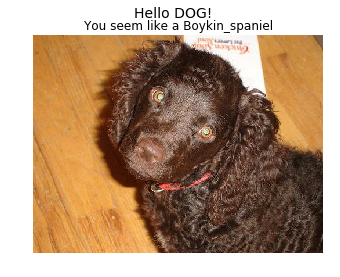

In [32]:
predict_dog_in_image('images/American_water_spaniel_00648.jpg')

Checking what dog you are ...


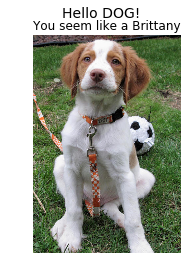

In [33]:
predict_dog_in_image('images/Brittany_02625.jpg')

Checking what dog you are ...


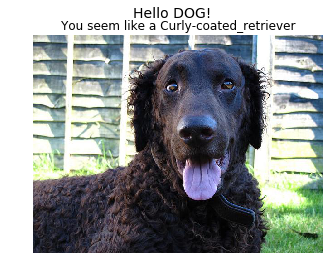

In [34]:
predict_dog_in_image('images/Curly-coated_retriever_03896.jpg')

Checking what dog you are ...


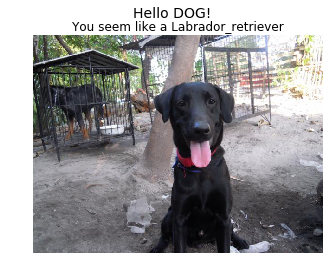

In [35]:
predict_dog_in_image('images/Labrador_retriever_06449.jpg')

Checking what dog you are ...


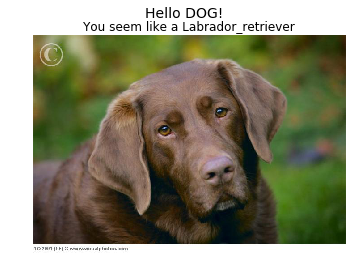

In [36]:
predict_dog_in_image('images/Labrador_retriever_06455.jpg')

Checking what dog you are ...


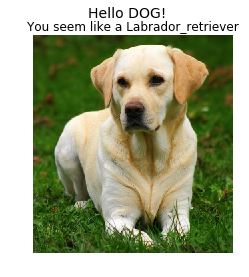

In [37]:
predict_dog_in_image('images/Labrador_retriever_06457.jpg')

Checking what dog you are ...


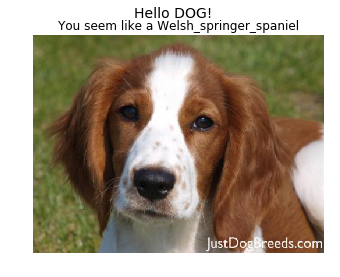

In [38]:
predict_dog_in_image('images/Welsh_springer_spaniel_08203.jpg')

Checking what dog you are ...
You seem to be a mix of:
Yorkshire_terrier with 0.14598409831523895 probability
and English_springer_spaniel with 0.13350646197795868 probability


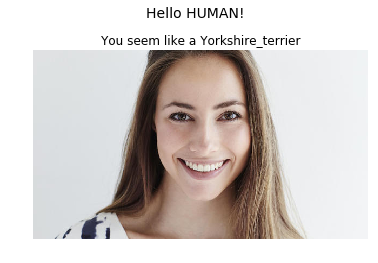

In [39]:
predict_dog_in_image('images/woman.jpg')

Checking what dog you are ...
You seem to be a mix of:
Maltese with 0.19343630969524384 probability
and Chesapeake_bay_retriever with 0.12613360583782196 probability


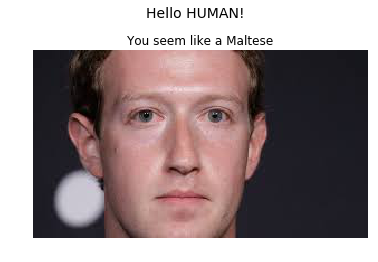

In [40]:
predict_dog_in_image('images/mark.jpg')

Checking what dog you are ...
Unable to detect a dog or a human in the image.
 May be this is a cat!


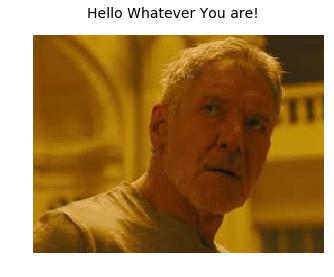

In [41]:
predict_dog_in_image('images/jones.jpg')